# Labor Two-Party Preferred Vote - LOESS Trend Analysis

This notebook visualizes the trend in Labor's two-party preferred (2PP) vote using LOESS smoothing from Wikipedia polling data.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess

from common import RFOOTER, COLOR_LABOR
LFOOTER = "Data: Polling data from Wikipedia"
SHOW_PLOT = True


In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/labor-2pp/")
mg.clear_chart_dir()

## Upload the data

In [3]:
def load_polling_data() -> pd.DataFrame:
    """Load the most recent polling data with data freshness validation."""
    today = pd.Timestamp.now().strftime('%Y-%m-%d')
    data_dir = Path("../poll-data")

    # Look for today's file first
    today_file = data_dir / f"voting_intention_next_{today}.csv"
    fallback_file = data_dir / "voting_intention_next.csv"

    if today_file.exists():
        data_path = today_file
        print(f"Using today's data file: {data_path}")
    else:
        # Look for any recent file with date suffix
        pattern = "voting_intention_next_*.csv"
        recent_files = list(data_dir.glob(pattern))
        
        if recent_files:
            # Sort by filename (date suffix) and take most recent
            most_recent = sorted(recent_files)[-1]
            file_date = most_recent.stem.split('_')[-1]  # Extract date from filename
            
            print(f"⚠️  WARNING: No data file found for today ({today})")
            print(f"Using most recent file: {most_recent} (from {file_date})")
            print(f"Consider running the scraper first: python scrape_wikipedia_polls.py")
            data_path = most_recent
        elif fallback_file.exists():
            print(f"⚠️  WARNING: No dated data files found")
            print(f"Using fallback file: {fallback_file}")
            print(f"Consider running the scraper first: python scrape_wikipedia_polls.py")
            data_path = fallback_file
        else:
            raise FileNotFoundError(f"No polling data files found. Please run the scraper first: python scrape_wikipedia_polls.py")

    # Load the data
    df = pd.read_csv(data_path)
    df.index = pd.PeriodIndex(df['date'], freq='D')

    # Filter for rows with 2PP data
    df_2pp = df[df['2pp_alp'].notna()].copy()

    return df_2pp


df_2pp = load_polling_data()

Using today's data file: ../poll-data/voting_intention_next_2025-07-21.csv


## Data Preview

In [4]:
def preview_polling_data(df_2pp: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(df_2pp[['original_date', 'date', 'brand', '2pp_alp', '2pp_lnp']].head(10))

# Show the data preview
preview_polling_data(df_2pp)

,original_date,date,brand,2pp_alp,2pp_lnp
date,,,,,
2025-05-18,5 May – 1 Jun 2025,2025-05-18,Roy Morgan,58.5,41.5
2025-06-12,2 – 22 Jun 2025,2025-06-12,Roy Morgan,58.0,42.0
2025-06-25,Late June 2025,2025-06-25,Redbridge,55.5,44.5
2025-06-26,23 – 29 Jun 2025,2025-06-26,Roy Morgan,57.5,42.5
2025-06-29,27 Jun – 1 Jul 2025,2025-06-29,Spectre Strategy,56.5,43.5
2025-07-05,5 – 6 Jul 2025,2025-07-05,DemosAU,59.0,41.0
2025-07-15,13 – 18 Jul 2025,2025-07-15,Resolve,56.0,44.0
2025-07-15,14 – 17 Jul 2025,2025-07-15,Newspoll,57.0,43.0


## LOESS Smoothing

In [5]:
def create_loess_smoothing(df_2pp: pd.DataFrame, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_2pp_sorted = df_2pp.sort_index().copy()
    
    # Convert period index to datetime for numeric conversion
    dates_as_ordinals = [p.ordinal for p in df_2pp_sorted.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1

    # Apply LOESS smoothing
    smoothed = lowess(
        df_2pp_sorted['2pp_alp'], 
        dates_as_ordinals,
        frac=fraction  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=df_2pp_sorted.index)
    smoothed_series.name = f'LOESS {day_span}-day smoothing'
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep='first')]
    return smoothed_series

smoothed = create_loess_smoothing(df_2pp)

## Data visualisation

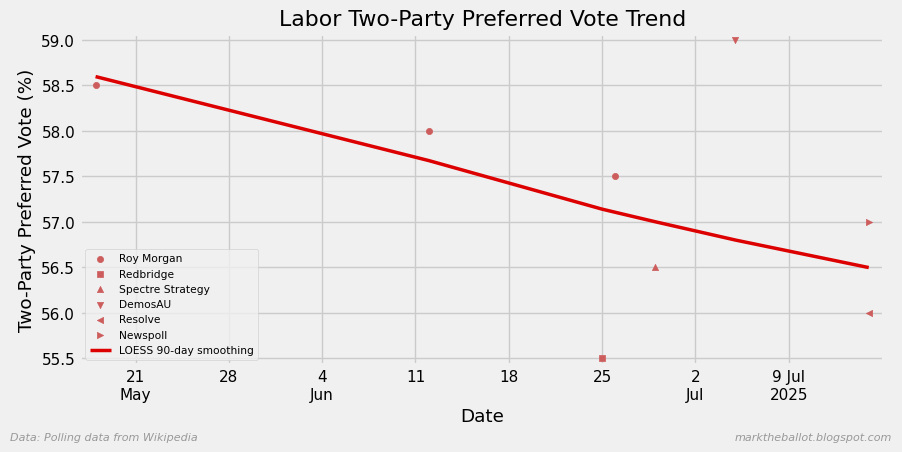

In [6]:
def create_chart_with_loess(df_2pp: pd.DataFrame, smoothed: pd.Series) -> None:
    """Create and display the LOESS chart with polling data."""

    fig, ax = plt.subplots()
    symbols = ['o', 's', '^', 'v', '<', '>', 'D', 'x', 'v']
    for i, label in enumerate(df_2pp['brand'].unique()):
        selection = df_2pp[df_2pp['brand'] == label]['2pp_alp']
        x = [p.ordinal  for p in selection.index]
        y = selection.to_numpy()
        ax.scatter(x, y, label=label, color=COLOR_LABOR, s=20, marker=symbols[i % len(symbols)])

    mg.line_plot_finalise(
        smoothed,
        ax=ax,
        title="Labor Two-Party Preferred Vote Trend",
        xlabel="Date",
        ylabel="Two-Party Preferred Vote (%)",
        legend=True,
        width=2.5,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW_PLOT,
    )

# Create and display the chart
create_chart_with_loess(df_2pp, smoothed)

## Finished

In [7]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-07-21 23:53:05

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pathlib    : 1.0.1
pandas     : 2.3.1
mgplot     : 0.2.11
matplotlib : 3.10.3
statsmodels: 0.14.5
numpy      : 2.3.1

Watermark: 2.5.0



In [8]:
print("The end.")

The end.
